Starting Random Search...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random Search completed in 44.40 seconds

Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 452}
Best CV Score: 0.9150

Training Accuracy: 0.9671
Test Accuracy: 0.9217
Fit Status: ✓ Best Fit / Well-Generalized

Classification Report:
              precision    recall  f1-score   support

       Large       0.81      0.86      0.84        66
      Medium       0.94      0.96      0.95       473
       Small       0.91      0.66      0.76        61

    accuracy                           0.92       600
   macro avg       0.89      0.83      0.85       600
weighted avg       0.92      0.92      0.92       600



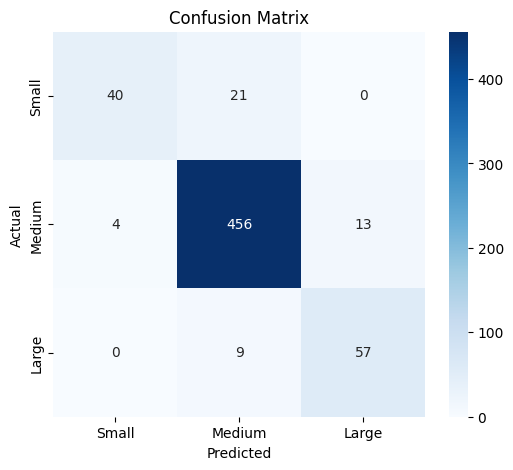

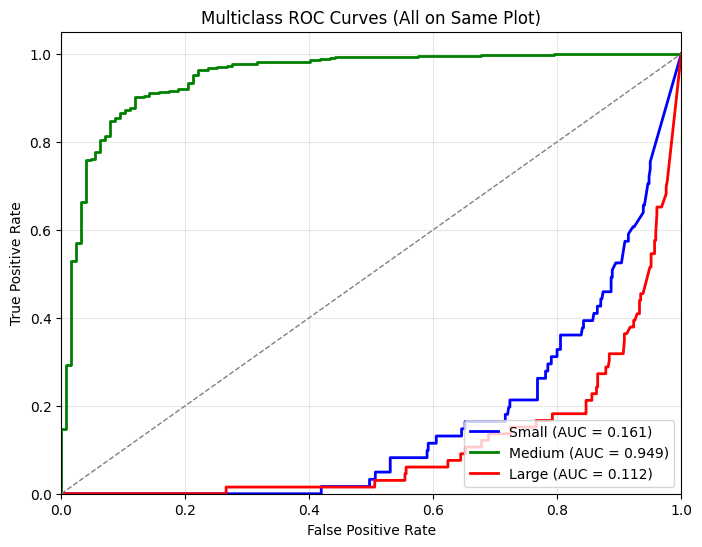

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from scipy.stats import randint

# --------------------------
# Generate synthetic dataset
# --------------------------
np.random.seed(42)
n_samples = 2000

size_sqft = np.random.normal(2000, 500, n_samples).clip(600, 4000)
num_bedrooms = np.random.choice([1, 2, 3, 4, 5], n_samples, p=[0.1, 0.25, 0.4, 0.2, 0.05])
num_bathrooms = np.random.choice([1, 2, 3, 4], n_samples, p=[0.2, 0.4, 0.3, 0.1])
age_years = np.random.randint(0, 50, n_samples)
location_score = np.random.uniform(1, 10, n_samples)

price = (
    size_sqft * 150 +
    num_bedrooms * 10000 +
    num_bathrooms * 7000 +
    (50 - age_years) * 1000 +
    location_score * 5000 +
    np.random.normal(0, 20000, n_samples)
)

labels = []
for p in price:
    if p < 300000:
        labels.append("Small")
    elif p < 500000:
        labels.append("Medium")
    else:
        labels.append("Large")

data = pd.DataFrame({
    'size_sqft': size_sqft,
    'num_bedrooms': num_bedrooms,
    'num_bathrooms': num_bathrooms,
    'age_years': age_years,
    'location_score': location_score,
    'house_size': labels
})

# --------------------------
# Split dataset
# --------------------------
X = data.drop('house_size', axis=1)
y = data['house_size']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --------------------------
# Randomized Search
# --------------------------
param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'log2', None]
}

print("Starting Random Search...")
start_time = time.time()

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=100,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)
end_time = time.time()
print(f"Random Search completed in {end_time - start_time:.2f} seconds")

best_model = random_search.best_estimator_
print(f"\nBest Parameters: {random_search.best_params_}")
print(f"Best CV Score: {random_search.best_score_:.4f}")

# --------------------------
# Evaluate model
# --------------------------
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"\nTraining Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Overfit/Underfit check
gap = train_acc - test_acc
if gap <= 0.05:
    fit_status = "✓ Best Fit / Well-Generalized"
elif gap <= 0.12:
    fit_status = "⚠ Moderate Overfitting"
else:
    fit_status = "✗ High Overfitting"

print(f"Fit Status: {fit_status}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# --------------------------
# Confusion Matrix
# --------------------------
cm = confusion_matrix(y_test, y_pred_test, labels=["Small", "Medium", "Large"])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Small", "Medium", "Large"], yticklabels=["Small", "Medium", "Large"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# --------------------------
# ROC AUC (One-vs-Rest for multiclass)
# --------------------------
y_test_bin = label_binarize(y_test, classes=["Small", "Medium", "Large"])
y_score = best_model.predict_proba(X_test)

plt.figure(figsize=(8,6))
colors = ['blue', 'green', 'red']
class_names = ["Small", "Medium", "Large"]

for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

# Diagonal line
plt.plot([0,1], [0,1], color='gray', linestyle='--', lw=1)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves (All on Same Plot)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
